In [1]:
import pandas as pd
import matplotlib.pyplot as matplt
import matplotlib.dates as mdates
from matplotlib.ticker import MultipleLocator
from datetime import datetime
from sklearn.cluster import KMeans
import matplotlib.colors
import numpy as np
from sklearn.preprocessing import StandardScaler
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
# Converts text to CSV
def txt_to_csv(fileName, sortBy = None):
    separator = '|'
    dataFrame = pd.read_csv('data/' + fileName + '.txt', delimiter= separator)
    dataFrame.columns = dataFrame.columns.str.strip()  # strips whitespace from columns
    dataFrame = dataFrame.map(lambda x: x.strip() if isinstance(x, str) else x) # strips whitespace from values
    
    if (sortBy):
        dataFrame.sort_values([sortBy], axis=0, ascending=[True], inplace=True)
    dataFrame.to_csv('data/' + fileName + '.csv', index = None)


txtDataFiles = ['iris-event-list', 'iris-station-list']
for file in txtDataFiles:
    txt_to_csv(fileName= file, sortBy= 'station')

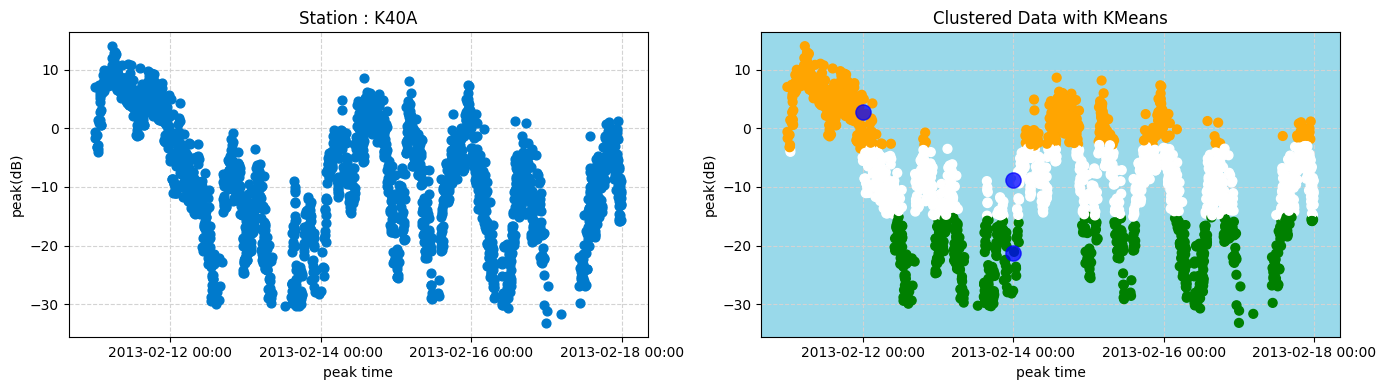

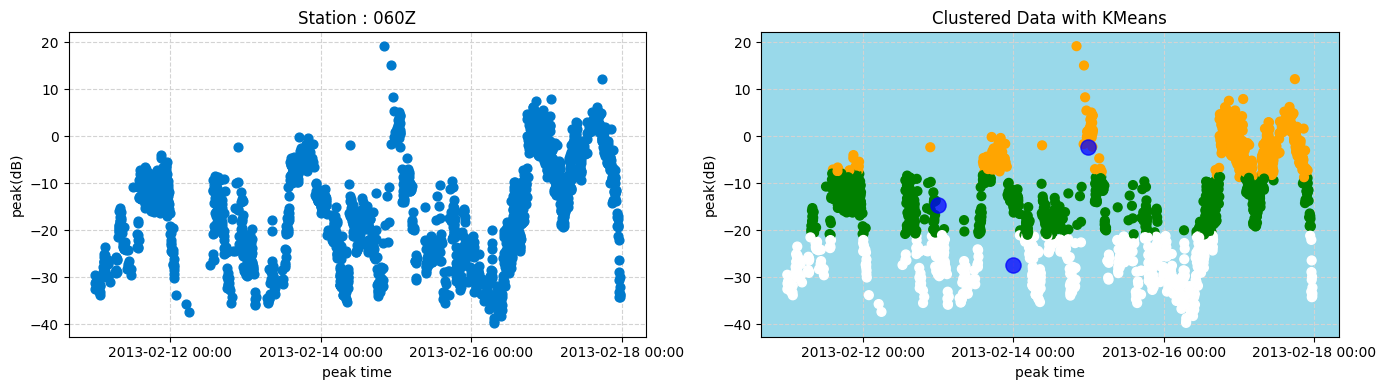

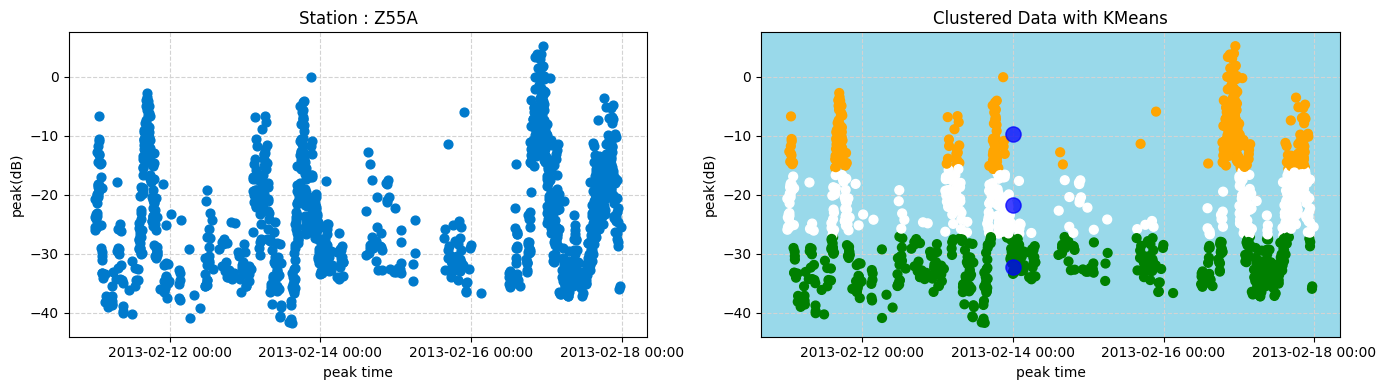

In [3]:
# Generates Scatter Plots
def generateScatterPlots(csvData, stations, feature1, feature2):
    
    csvRecords = csvData
    for station in stations:
        fig, axs = matplt.subplots(1, 2, figsize=(14, 4), layout="tight")
        plot1 = axs[0]
        plot2 = axs[1]

        # filtering data as per research station 
        data = csvRecords[csvRecords[idColumn] == station]
       
        # convert datetime string into datetime obj
        data[feature1] = [datetime.strptime(date, '%Y-%m-%d %H:%M:%S') for date in data[feature1]]
        dateOrdinal = data[feature1].map(pd.Timestamp.toordinal)

        # feature values
        f1Values = data[feature1]
        f2Vlaues = data[feature2]
        
        # scatter plot 1
        plot1.set_title('Station : ' + station)
        plot1.scatter(x= f1Values, y= f2Vlaues, c= '#007acc', s= 40)

        # generating clusters
        fillData = np.column_stack((dateOrdinal, f2Vlaues))
        kmeans = KMeans(n_clusters= 3, random_state= 2024)
        kmeans.fit(fillData)
        y_kmeans = kmeans.predict(fillData)

        # scatter plot 2
        # plotting the Clusters
        plot2.set_title('Clustered Data with KMeans')
        cmapIN = matplotlib.colors.LinearSegmentedColormap.from_list("", ["green","orange","white"])
        plot2.set_facecolor("#99D9EA")
        plot2.scatter(f1Values, f2Vlaues, c=y_kmeans, s=40, cmap= cmapIN)

        # plotting the centroids
        centroids = kmeans.cluster_centers_
        centroids_dates = [pd.Timestamp.fromordinal(int(c[0])) for c in centroids]
        plot2.scatter(centroids_dates, centroids[:, 1], c='b', s=120, alpha=0.75)
        
        # setting interval for x axis
        plot1.yaxis.set_major_locator(MultipleLocator(10))
        plot2.yaxis.set_major_locator(MultipleLocator(10))

        # setting interval for y axis
        plot1.xaxis.set_major_locator(mdates.HourLocator(byhour= 00))
        plot1.xaxis.set_major_locator(mdates.DayLocator(interval= 2))
        plot1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
        plot2.xaxis.set_major_locator(mdates.HourLocator(byhour= 00))
        plot2.xaxis.set_major_locator(mdates.DayLocator(interval= 2))
        plot2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))

        # adding dashed grid 
        plot1.set_axisbelow(True)
        plot1.grid(color='lightgray', linestyle='dashed')
        plot2.set_axisbelow(True)
        plot2.grid(color='lightgray', linestyle='dashed')

        # setting x & y labels
        plot1.set_xlabel(feature1)
        plot1.set_ylabel(feature2)
        plot2.set_xlabel(feature1)
        plot2.set_ylabel(feature2)

        matplt.show()

records = pd.read_csv('data/iris-event-list.csv')
stations = ['K40A', '060Z', 'Z55A']
f1Column = 'peak time'
f2Column = 'peak(dB)'
idColumn = 'station'

generateScatterPlots(csvData= records, stations= stations, feature1= f1Column, feature2= f2Column)

In [4]:
def getStationData(id):
    return records[records[idColumn] == id]

def calculate_statistics(cluster_data): 

    return {
        'mean_peak_dB'       : cluster_data['peak(dB)'].mean(),
        'max_peak_dB'        : cluster_data['peak(dB)'].max(),
        'mean_duration'      : cluster_data['duration'].mean(),  # in hours
        'mean_background_dB' : cluster_data['background(dB)'].mean(),
        'max_background_dB'  : cluster_data['background(dB)'].max(),
        'mean_snr'           : cluster_data['snr'].mean(),
        'max_snr'            : cluster_data['snr'].max(),
        'max_duration'       : cluster_data['duration'].max(),
        'start_time'         : cluster_data['start time'].mean(),
        'end_time'           : cluster_data['end time'].mean()
    }


def preprocess_data(df):
    time_columns = ['start time', 'peak time', 'end time']
    for col in time_columns:
        df[col] = pd.to_datetime(df[col])
    df['duration'] = (df['end time'] - df['start time']).dt.total_seconds()
    df['snr'] = df['peak(dB)'] - df['background(dB)'] # Example of a derived measure
    return df


# Function to perform clustering and calculate average duration
def cluster_and_analyze(data, n_clusters=3):

    data = preprocess_data(data)
    results = []

    for station in data['station'].unique():
        station_data = data[data['station'] == station]
        dynamic_k_cluster = len(station_data) if len(station_data) < n_clusters else n_clusters

        # Extract features for clustering
        featureData = station_data[['peak time', 'peak(dB)']].copy()
        featureData['peak time'] = featureData['peak time'].astype(np.int64) // 10**9  # Convert to Unix timestamp

        # Standardize features
        scaler = StandardScaler()
        featureData_scaled = scaler.fit_transform(featureData)

        # Perform k-means clustering
        kmeans = KMeans(n_clusters= dynamic_k_cluster, random_state= 42)
        station_data['cluster'] = kmeans.fit_predict(featureData_scaled)

        centroids = kmeans.cluster_centers_
        print("Centroids of the clusters:")
        print(centroids)

        for cluster in range(dynamic_k_cluster):
            
            cluster_data = station_data[station_data['cluster'] == cluster]
            stats = {
                'station': station,
                'cluster': cluster
            } | calculate_statistics(cluster_data)
            results.append(stats)
        
    return pd.DataFrame(results)

print(cluster_and_analyze(records, 3).to_csv('data/result.csv'))

Centroids of the clusters:
[[ 0.87487372  1.13185944]
 [-0.92973984 -0.21600781]
 [ 0.70836899 -0.87286911]]
Centroids of the clusters:
[[ 0.05873918 -1.04234352]
 [-0.93330251  0.34071404]
 [ 1.17152327  0.95470646]]
Centroids of the clusters:
[[ 5.11229404e-05 -1.16822835e+00]
 [ 1.15350429e+00  6.04018372e-01]
 [-8.58718929e-01  4.64791264e-01]]
Centroids of the clusters:
[[ 1.15713322  0.68584031]
 [-0.88632163  0.45905329]
 [-0.11843503 -1.17808762]]
Centroids of the clusters:
[[ 0.99459937  1.02216058]
 [-1.14404979  0.02686381]
 [ 0.16116527 -0.93240958]]
Centroids of the clusters:
[[ 0.92401673  0.78211987]
 [ 0.18176553 -1.23079492]
 [-1.05756747  0.27931599]]
Centroids of the clusters:
[[ 0.19120722 -1.11650962]
 [ 0.95656869  0.84389301]
 [-1.19047247 -0.04594641]]
Centroids of the clusters:
[[ 0.72443175 -0.75484496]
 [-0.91833226  0.06334624]
 [ 0.82421556  0.86131018]]
Centroids of the clusters:
[[-1.14171635 -0.92044177]
 [ 1.08612056  1.05275926]
 [-0.29141822 -0.442368